# `provabgs` external test
Test the `provabgs` pipeline on external spectral mocks --- namely the `gqp_mc` spectral mocks constructed the from the `LGalaxies` SAM

In [1]:
import os
import numpy as np 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
#    mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
from gqp_mc import util as UT
from gqp_mc import data as Data

In [3]:
from provabgs import infer as Infer
from provabgs import models as Models

/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:25: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


# read GQP Mock Challenge spectral mocks

In [4]:
specs, meta = Data.Spectra(sim='lgal', noise='bgs', sample='mini_mocha')
specs_nonoise, _ = Data.Spectra(sim='lgal', noise='none', sample='mini_mocha')

Text(0.5, 0, 'wavelength')

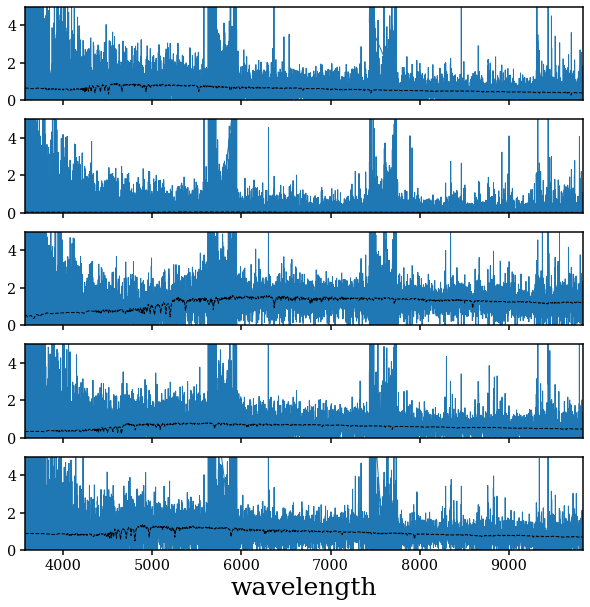

In [5]:
fig = plt.figure(figsize=(10,10))
for i in range(5): 
    sub = fig.add_subplot(5,1,i+1)
    sub.plot(specs['wave'], specs['flux'][i], lw=1)
    sub.plot(specs_nonoise['wave'], specs_nonoise['flux'][i], c='k', lw=1, ls='--')
    sub.set_xlim(specs['wave'].min(), specs['wave'].max())
    sub.set_ylim(0., 5)
    if i < 4: sub.set_xticklabels([])
sub.set_xlabel('wavelength', fontsize=25)

In [6]:
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')      # uniform priors on dust_index 
])
m_nmf = Models.NMF(burst=True, emulator=True)

In [7]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=prior
)

In [8]:
mcmc_chain = desi_mcmc.run(
    wave_obs=[specs['wave_b'], specs['wave_r'], specs['wave_z']], 
    flux_obs=[specs['flux_b'][0], specs['flux_r'][0], specs['flux_z'][0]], 
    flux_ivar_obs=[specs['ivar_b'][0], specs['ivar_r'][0], specs['ivar_z'][0]],
    resolution=[specs['res_b'][0], specs['res_r'][0], specs['res_z'][0]],
    zred=meta['redshift'][0], 
    mask='emline',
    vdisp=50.,
    sampler='zeus',
    nwalkers=30, 
    burnin=0,
    opt_maxiter=2000,
    niter=1500, 
    debug=True)

--- initializing the walkers ---


/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:908: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:908: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:849: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[

initial theta = [9.000000015519843, 0.9510921543618139, 0.9999998020162514, 0.20443760114437282, 0.08577462804951647, 4.095332003422581, 0.005682037179340309, 0.002931049026105044, 1.9624469691407134, 0.15255069184531023, -0.989736869530534]
log Posterior(theta0) = -4515.222218
--- running MCMC ---


Sampling progress : 100%|██████████| 1500/1500 [39:51<00:00,  1.59s/it]

bestfit theta = [9.000088877149325, 0.10765074450177836, 0.02522887918129451, 0.6000150759293053, 0.26710530038762187, 0.018987922897124053, 0.0035535407944003354, 7.435244759016964e-05, 7.379495362065251e-05, 0.7216529069994303, 0.6154495580203924, 0.016171972271585157]
log Posterior = -4163.797677
Model.sed: redshift = 0.135631
Model.sed: ssp lum [106941.66191728 106716.7470664  102662.53036842 ...  44515.31788718
  44484.19319698  44315.81463137]


# compare bestfit spectra

(0.0, 5)

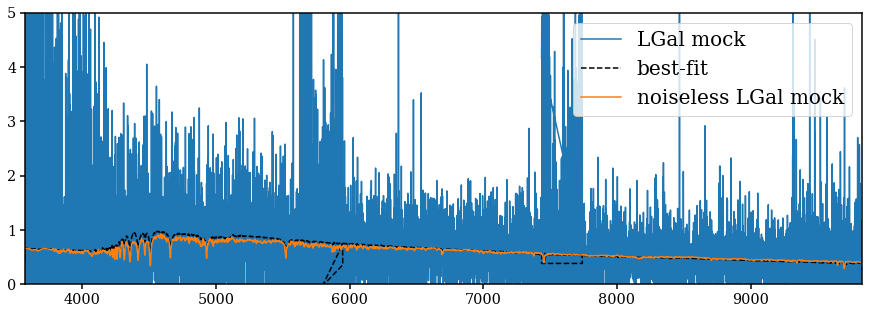

In [18]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(111)
sub.plot(mcmc_chain['wavelength_obs'], mcmc_chain['flux_spec_obs'], label='LGal mock')
sub.plot(mcmc_chain['wavelength_obs'], mcmc_chain['flux_spec_model'], c='k', ls='--', label='best-fit')
sub.plot(specs_nonoise['wave'], specs_nonoise['flux'][0], label='noiseless LGal mock')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlim(mcmc_chain['wavelength_obs'].min(), mcmc_chain['wavelength_obs'].max())
sub.set_ylim(0., 5)